# PACKAGES

In [1]:
# packages
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime as dt
from datetime import timedelta

# DATA

In [2]:
df1 = pd.read_csv('../goodtrainbadtrain/data/select2_2020.csv',sep=',')
df2 = pd.read_csv('../goodtrainbadtrain/data/select2_2021.csv',sep=',')
df3 = pd.read_csv('../goodtrainbadtrain/data/select2_2022.csv',sep=',')

df = pd.concat([df1, df2, df3])

# FILTER

In [3]:
#filter for München and Köln
df = df.query("bhf in ('München Hbf', 'Köln Hbf',  'Köln Messe/Deutz Gl.11-12',  'Frankfurt(M) Flughafen Fernbf', 'Mannheim Hbf',  'Stuttgart Hbf','Würzburg Hbf', 'Frankfurt(Main) Hbf','Nürnberg Hbf','Berlin Hbf', 'Berlin Hbf (tief)','Hamburg Hbf','Essen Hbf','Hagen(Westf) Bahnhof','Hagen Hbf','Hannover Hbf','Erfurt Hbf','Göttingen')")

# PROCESS AND CLEAN

In [4]:
#1) cleaning of train names 
#some letters of 'zugnr' are not capitalized
df['zugnr'] = df['zugnr'].str.upper()

#2)process of 9999 in arrTime and depTime: add new column with info 
df['start_or_endpoint'] = 'nan'
df.loc[df['arrTime'] == 9999, 'start_or_endpoint'] = 'start'
df.loc[df['depTime'] == 9999, 'start_or_endpoint'] = 'end'
#overwrite 9999 with respective arr/dep time of same observation (in new clean columns)
df['arrTime_clean'] = np.where(df['arrTime'] == 9999, df['depTime'], df['arrTime'])
df['depTime_clean'] = np.where(df['depTime'] == 9999, df['arrTime'], df['depTime'])

#3)some times need to be filled up with 0's. eg. '5' -> 00:05
df['arrTime_clean'] = df['arrTime_clean'].astype(str)
df['arrTime_clean'] = df['arrTime_clean'].map(lambda a: a.zfill(4))
df['depTime_clean'] = df['depTime_clean'].astype(str)
df['depTime_clean'] = df['depTime_clean'].map(lambda a: a.zfill(4))

# FEATURE ENGENEERING

In [6]:
#1)add city feature (merged Köln Hbf/ Messe Deutz)
df['city'] = df.bhf

city_dictionary = {'Köln Messe/Deutz Gl.11-12':'Köln',
              'Köln Hbf':'Köln',
              'München Hbf':'München',
              'Frankfurt(M) Flughafen Fernbf':'Frankfurt',
              'Frankfurt(Main) Hbf':'Frankfurt',
              'Nürnberg Hbf':'Nürnberg',
              'Stuttgart Hbf':'Stuttgart',
              'Würzburg Hbf':'Würzburg',
              'Mannheim Hbf':'Mannheim',
              'Essen Hbf':'Essen',
              'Hamburg Hbf':'Hamburg',
              'Berlin Hbf':'Berlin',
              'Berlin (tief)':'Berlin',
              'Hannover Hbf':'Hannover',
              'Berlin Hbf (tief)':'Berlin',
              'Hagen Hbf':'Hagen',
              'Erfurt Hbf':'Erfurt', 
              'Göttingen':'Göttingen'} 

for key in city_dictionary.keys():
    df['city'] = df['city'].str.replace(key, city_dictionary[key])
     
#code above does not work for berlin and frankfurt; workaround:
df['city'] = df['city'].apply(lambda x: x.replace('Frankfurt(M) Flughafen Fernbf','Frankfurt'))
df['city'] = df['city'].apply(lambda x: x.replace('Berlin (tief)','Berlin'))

#2) add date column
df['date'] = df['datum'] + ' ' + df['arrTime_clean']
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d %H%M')

#3a) add weekday 
df['weekday'] = df['date'].dt.day_name()

#3a) add binary weekend-week 
df['weekend'] = (df['weekday'] == 'Sunday') | (df['weekday'] == 'Saturday')

#4) add month of the year 
df['month'] = df['date'].dt.month_name()

#time of the day
df['time_of_day'] = pd.cut(pd.to_datetime(df.date).dt.hour,
       bins=[0, 6, 12, 18, 24],
       labels=['night', 'morning', 'afternoon', 'evening'],
       right=False,
       include_lowest=True)

#5 time of day in circular 
seconds_in_day = 24*60*60
df['seconds'] = pd.to_datetime(df.date).dt.time.astype(str)
df['seconds'] = df['seconds'].map(lambda a: sum(x * int(t) for x, t in zip([3600, 60, 1], a.split(":"))))
df['sin_time'] = np.sin(2*np.pi*df.seconds/seconds_in_day)
df['cos_time'] = np.cos(2*np.pi*df.seconds/seconds_in_day)
df.drop('seconds', axis=1, inplace=True)

#6 circular day of the year
from datetime import date
days_in_year = 366
df['day_of_year'] = df.date.map(lambda x: x.strftime('%j')).astype(int)
df['sin_day'] = np.sin(2*np.pi*df.day_of_year/days_in_year)
df['cos_day'] = np.cos(2*np.pi*df.day_of_year/days_in_year)
df.drop('day_of_year', axis=1, inplace=True)

#todo
#7) add public holiday
holidays = pd.read_csv('../goodtrainbadtrain/data/holidays.csv',sep=',')
holidays = holidays['date'].to_list()

def check_holiday(date):
    if date in holidays:
        return True
    else:
        return False

df['public_holiday'] =  df.datum.map(lambda x: check_holiday(x))

#8) add covid lockdown
def process_time(intime, start, end):
    if start <= intime <= end:
        return True
    else:
        return False

start1 = dt.fromisoformat('2020-03-15'); end1 = dt.fromisoformat('2020-06-23')
start2 = dt.fromisoformat('2021-01-10'); end2 = dt.fromisoformat('2021-05-24')

df['covid_lockdown1'] = df['date'].map(lambda x: process_time(x, start1, end1))
df['covid_lockdown2'] = df['date'].map(lambda x: process_time(x, start2, end2))

df['covid_lockdown'] = df['covid_lockdown1'] | df['covid_lockdown2']
df.drop('covid_lockdown1',axis=1, inplace=True)
df.drop('covid_lockdown2',axis=1, inplace=True)

/var/folders/qr/sbnhxw8x63b6sw4qtnjdcnb00000gn/T/ipykernel_2289/681295108.py:24: FutureWarning: The default value of regex will change from True to False in a future version.
  df['city'] = df['city'].str.replace(key, city_dictionary[key])


# ADD DIRECTON INFO

In [7]:
journeys = pd.read_csv('../goodtrainbadtrain/data/journeylist_withberlin.csv')

#processing
journeys = journeys[journeys.leg1_train.notna()] #delete duplicated trips that once go to köln hbf and once to deutz
journeys = journeys[journeys.leg2_train.notna()] 
journeys = journeys[journeys.leg3_train.notna()] 

journeys = journeys.drop(['Unnamed: 0'],axis=1) 
journeys['key_ID'] = list(range(journeys.shape[0]))

#rename columns (necessary for wide_to_long function)
journeys.columns = [ 'date', 'weekday', 'month', 'journey_origin',
       'journey_destination', 'journey_start', 'journey_end',
       'journey_duration', 'journey_numberlegs', 
       'train_leg1', 'origin_leg1','destination_leg1', 'start_leg1', 'end_leg1', 'duration_leg1',
       'train_leg2', 'origin_leg2', 'destination_leg2', 'start_leg2','end_leg2', 'duration_leg2', 
       'train_leg3', 'origin_leg3','destination_leg3', 'start_leg3', 'end_leg3', 'duration_leg3', 
       'key_ID']

journeys_long = pd.wide_to_long(df = journeys,
                                stubnames=['train', 'origin','destination', 'start', 'end', 'duration'],
                                i=['key_ID'],
                                j='leg',
                                sep = '_',
                                suffix='.+').reset_index()

#delete empty legs
journeys_long = journeys_long[journeys_long.train != '-1']
journeys_long = journeys_long[journeys_long.origin != '-1']

#reorder columns
journeys_long = journeys_long[['key_ID', 
 'journey_origin', 'journey_destination','journey_start','journey_end','journey_duration', 'journey_numberlegs',
 'leg', 'train', 'origin', 'destination', 'start', 'end','duration',
 'date', 'month','weekday']]

def date_transformation(df, columns):
    for col in columns:
        df[col] = df[col].str.split('+', expand=True)[[0]]
        df[col] = pd.to_datetime(df[col])
    return df

journeys_long = date_transformation(journeys_long, ['journey_start', 'journey_end']) #, 'start', 'end'])
journeys_long['month'] = journeys_long['journey_start'].dt.month_name()
journeys_long['weekday'] = journeys_long['journey_start'].dt.day_name()

#add columns with city name
journeys_long['origin_city'] = journeys_long.origin
journeys_long['destination_city'] = journeys_long.destination

for key in city_dictionary.keys():
    journeys_long['origin_city'] = journeys_long['origin_city'].str.replace(key, city_dictionary[key])
    journeys_long['destination_city'] = journeys_long['destination_city'].str.replace(key, city_dictionary[key])
    
#code above does not work for berlin and frankfurt; workaround:
journeys_long['origin_city'] = journeys_long['origin_city'].apply(lambda x: x.replace('Frankfurt(M) Flughafen Fernbf','Frankfurt'))
journeys_long['origin_city'] = journeys_long['origin_city'].apply(lambda x: x.replace('Frankfurt(M) Flughafen Fernbf','Frankfurt'))
journeys_long['destination_city'] = journeys_long['destination_city'].apply(lambda x: x.replace('Berlin (tief)','Berlin'))
journeys_long['destination_city'] = journeys_long['destination_city'].apply(lambda x: x.replace('Berlin (tief)','Berlin'))


#add column trip (eg. Berlin-Köln)
journeys_long['trip'] = journeys_long['origin_city'] + '-' + journeys_long['destination_city']

ice_df = journeys_long[['origin_city','destination_city','trip','train']].groupby(['origin_city','destination_city','trip'])['train'].apply(','.join).reset_index()

df_list = []

for index, row in ice_df.iterrows():
    data = df[df.city == row.destination_city]
    data = data[data['zugnr'].isin(row.train.split(','))]
    data['trip'] = row.trip
    data['origin_city'] = row.origin_city
    data['destination_city'] = row.destination_city
    df_list.append(data) 

df = pd.concat(df_list, ignore_index = True)

/var/folders/qr/sbnhxw8x63b6sw4qtnjdcnb00000gn/T/ipykernel_2289/4022885334.py:52: FutureWarning: The default value of regex will change from True to False in a future version.
  journeys_long['origin_city'] = journeys_long['origin_city'].str.replace(key, city_dictionary[key])
/var/folders/qr/sbnhxw8x63b6sw4qtnjdcnb00000gn/T/ipykernel_2289/4022885334.py:53: FutureWarning: The default value of regex will change from True to False in a future version.
  journeys_long['destination_city'] = journeys_long['destination_city'].str.replace(key, city_dictionary[key])


# ADD WEATHER

In [8]:
#5) add weather variables
df['sharp_date'] = df['date'].dt.round('H')
#df['sharp_date']  = df.sharp_date.astype('str')

cgn_data = pd.read_csv('../goodtrainbadtrain/data/koln.csv', parse_dates=['time'])
muc_data = pd.read_csv('../goodtrainbadtrain/data/munchen.csv', parse_dates=['time'])

fra_data = pd.read_csv('../goodtrainbadtrain/data/frankfurt.csv', parse_dates=['time'])
man_data = pd.read_csv('../goodtrainbadtrain/data/mannheim.csv', parse_dates=['time'])
nur_data = pd.read_csv('../goodtrainbadtrain/data/nurnberg.csv', parse_dates=['time'])
stu_data = pd.read_csv('../goodtrainbadtrain/data/stuttgart.csv', parse_dates=['time'])
wur_data = pd.read_csv('../goodtrainbadtrain/data/wurzburg.csv', parse_dates=['time'])
ber_data = pd.read_csv('../goodtrainbadtrain/data/berlin.csv', parse_dates=['time'])
erf_data = pd.read_csv('../goodtrainbadtrain/data/erfurt.csv', parse_dates=['time'])
ess_data = pd.read_csv('../goodtrainbadtrain/data/essen.csv', parse_dates=['time'])
got_data = pd.read_csv('../goodtrainbadtrain/data/gottingen.csv', parse_dates=['time'])
hag_data = pd.read_csv('../goodtrainbadtrain/data/hagen.csv', parse_dates=['time'])
ham_data = pd.read_csv('../goodtrainbadtrain/data/hamburg.csv', parse_dates=['time'])
han_data = pd.read_csv('../goodtrainbadtrain/data/hannover.csv', parse_dates=['time'])


weather = {"Köln": cgn_data, 
           "München": muc_data, 
           "Frankfurt": fra_data, 
           "Mannheim": man_data, 
           "Nürnberg": nur_data, 
           "Stuttgart": stu_data,
           "Würzburg": wur_data,
           "Berlin": ber_data,
           "Erfurt" :erf_data,
            "Essen": ess_data,
            "Göttingen":got_data,
            "Hagen":hag_data,
            "Hamburg":ham_data,
            "Hannover":han_data
           }

# Load coco file
coco = pd.read_csv('../goodtrainbadtrain/data/weather_coco.csv', sep=';')
coco.set_index('Code', inplace=True)
coco = coco.to_dict()['Weather Condition']

# Define new classification for coco
new_classes = {
    '1': [1, 2],
    '2': [3, 4, 7, 14],
    '3': [5, 8, 10, 12, 15, 17, 19, 21, 23, 24, 25],
    '4': [6, 9, 11, 13, 16, 18, 20, 22, 26, 27]
}

# Apply new classification for coco
reclass = {}
for k, values in new_classes.items():
    for v in values:
        for c in range(1, 28):
            if v == c:
                reclass[v] = k

for k, w_df in weather.items():
    w_df['snow'] = w_df['snow'].replace(np.nan, 0)
    reclass = dict(sorted(reclass.items()))
    w_df['coco'] = w_df['coco'].map(reclass)

In [9]:
df['sharp_date'] = df['date'].dt.round('H')
c_hours = [6, 12]
c_cities = ['oc', 'dc'] # oc: origin city, dc: destination city
c_variables = ['temp', 'prcp', 'snow', 'wspd', 'wpgt', 'coco']
cases = [v + '_' + c + '_' + str(h) for h in c_hours for c in c_cities for v in c_variables] #list of origin and time combination
df[cases] = np.nan

In [10]:
cities = list(weather.keys())
cases = ['origin_city', 'destination_city']
hours = [6, 12]
for c in cities:
    for i in cases:
        weather_df = weather[c].drop(columns=['dwpt', 'rhum', 'wdir', 'pres', 'tsun'])
        if i == 'origin_city':
            ii = 'oc'
        elif i == 'destination_city':
            ii = 'dc'
        for h in hours:
            df['time -' + str(h) + 'H'] = df['sharp_date'] - timedelta(hours=h)
            weather_df_dummy = weather_df.rename(columns={'temp': 'temp_' + ii + '_' + str(h),
                            'prcp': 'prcp_' + ii + '_' + str(h),
                            'snow': 'snow_' + ii + '_' + str(h),
                            'wspd': 'wspd_' + ii + '_' + str(h),
                            'wpgt': 'wpgt_' + ii + '_' + str(h),
                            'coco': 'coco_' + ii + '_' + str(h)})
            weather_df_dummy['city'] = c

            df.set_index([i,'sharp_date'], inplace=True)
            df.update(weather_df_dummy.set_index(['city', 'time']))
            df.reset_index(inplace=True)


# TARGET PROCESSING

In [12]:
#1a) into several categories
# adelay-> into categories: no delay, small delay, medium delay, (big delay/cancellation)
max = df.adelay.max()
bins = [-2, -0.1, 0, 5, 30, max]
group_names = ['large delay/cancelled','on time','small delay', 'medium delay', 'large delay/cancelled']
df['target'] = pd.cut(df['adelay'], bins, labels=group_names, ordered=False)

#1b) into two categories: good - bad train
df['target_good_bad'] = df['target'].str.replace('large delay/cancelled','bad train')
df['target_good_bad'] = df['target_good_bad'].str.replace('medium delay','bad train')

df['target_good_bad'] = df['target_good_bad'].str.replace('on time','good train')
df['target_good_bad'] = df['target_good_bad'].str.replace('small delay','good train')

df['target_good_bad'] = df['target_good_bad'] == 'good train'

#value counts of target:
#on time                  67336
#small delay              28649
#medium delay             23617
#large delay/cancelled    10677

#2) binary target (on time - or not)
df['target_binary'] =  (df['adelay'] == 0)*1

#3) numeric target (cancelled and extreme values = 120 Min)
df['target_numeric'] = df['adelay']
df['target_numeric'] = np.where(df['target_numeric'] == -1, 120, df['target_numeric'])
df['target_numeric'] = np.where(df['target_numeric'] > 120, 120, df['target_numeric'])
#sns.boxplot(df['target_numeric'])

##Add summarized delay of each train number
df['target_numeric'] = df['adelay']
df['target_numeric'] = np.where(df['target_numeric'] == -1, 120, df['target_numeric'])
df['target_numeric'] = np.where(df['target_numeric'] > 120, 120, df['target_numeric'])

In [13]:
mean_delay_ices = df[['zugnr','target_numeric']].groupby('zugnr').mean('target_numeric').reset_index()
mean_delay_ices.columns = ['zugnr', 'mean_delay']
median_delay_ices = df[['zugnr','target_numeric']].groupby('zugnr').median('target_numeric').reset_index()
median_delay_ices.columns = ['zugnr', 'median_delay']

df = df.merge(mean_delay_ices, how='left', left_on='zugnr', right_on='zugnr')
df = df.merge(median_delay_ices, how='left', left_on='zugnr', right_on='zugnr')

In [14]:
df[['target_good_bad',  'mean_delay', 'median_delay']].corr()

,target_good_bad,mean_delay,median_delay
target_good_bad,1.000000,-0.208787,-0.210951
mean_delay,-0.208787,1.000000,0.792923
median_delay,-0.210951,0.792923,1.000000


# CORRELATION / TARGET VISUALIZATION

<AxesSubplot:xlabel='weekday', ylabel='target_numeric'>

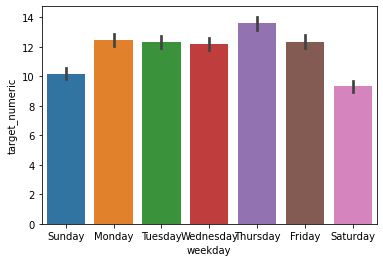

In [13]:
sns.barplot(x= df.weekday, y=df.target_numeric)

<AxesSubplot:xlabel='public_holiday', ylabel='target_good_bad'>

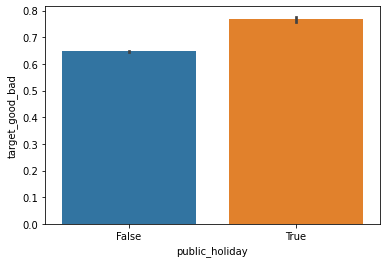

In [114]:
sns.barplot(x= df.public_holiday, y=df.target_good_bad)

<AxesSubplot:xlabel='weekday', ylabel='target_good_bad'>

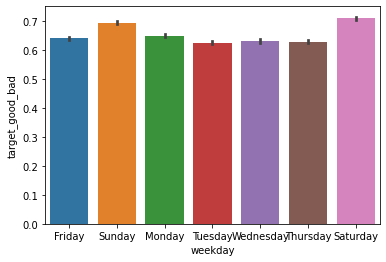

In [57]:
sns.barplot(x= df.weekday, y=df.target_good_bad)

<AxesSubplot:xlabel='weekend', ylabel='target_good_bad'>

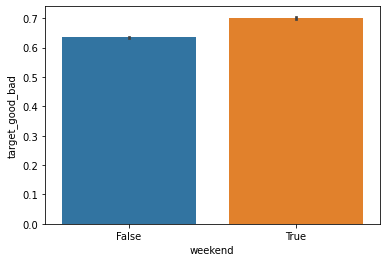

In [56]:
sns.barplot(x= df.weekend, y=df.target_good_bad)

<AxesSubplot:xlabel='covid_lockdown', ylabel='target_good_bad'>

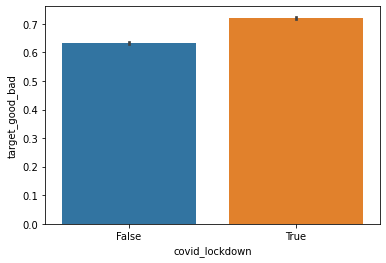

In [58]:
sns.barplot(x= df.covid_lockdown, y=df.target_good_bad)

<AxesSubplot:xlabel='month', ylabel='target_good_bad'>

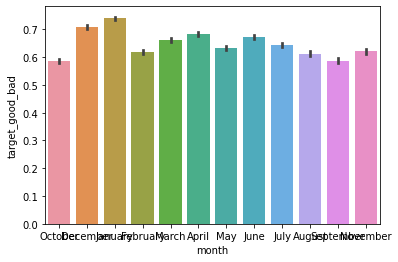

In [55]:
sns.barplot(x= df.month, y=df.target_good_bad)

<AxesSubplot:xlabel='target_good_bad', ylabel='sin_time'>

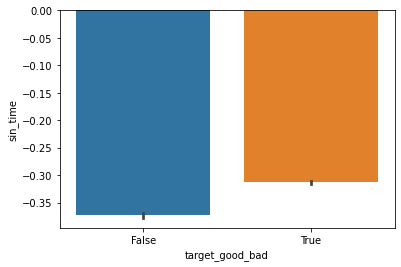

In [64]:
binary= df.target_good_bad == True
sns.barplot( x=binary, y= df.sin_time)


<AxesSubplot:xlabel='target_good_bad', ylabel='cos_time'>

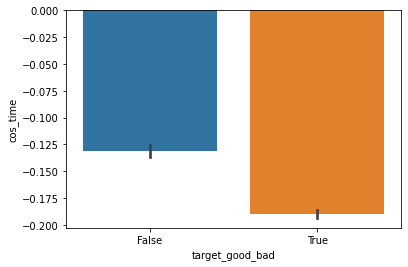

In [65]:
binary= df.target_good_bad == True
sns.barplot( x=binary, y= df.cos_time)

<AxesSubplot:xlabel='sin_time', ylabel='cos_time'>

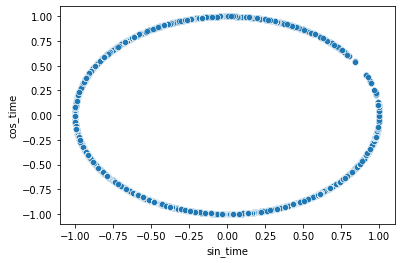

In [67]:
sns.scatterplot(x= df.sin_time, y=df.cos_time)

# SAVE DATA

In [15]:
df.columns

Index(['destination_city', 'sharp_date', 'origin_city', 'zugnr', 'datum',
       'bhf', 'arrTime', 'adelay', 'depTime', 'ddelay', 'start_or_endpoint',
       'arrTime_clean', 'depTime_clean', 'city', 'date', 'weekday', 'weekend',
       'month', 'time_of_day', 'sin_time', 'cos_time', 'sin_day', 'cos_day',
       'public_holiday', 'covid_lockdown', 'trip', 'temp_oc_6', 'prcp_oc_6',
       'snow_oc_6', 'wspd_oc_6', 'wpgt_oc_6', 'coco_oc_6', 'temp_dc_6',
       'prcp_dc_6', 'snow_dc_6', 'wspd_dc_6', 'wpgt_dc_6', 'coco_dc_6',
       'temp_oc_12', 'prcp_oc_12', 'snow_oc_12', 'wspd_oc_12', 'wpgt_oc_12',
       'coco_oc_12', 'temp_dc_12', 'prcp_dc_12', 'snow_dc_12', 'wspd_dc_12',
       'wpgt_dc_12', 'coco_dc_12', 'time -6H', 'time -12H', 'target',
       'target_good_bad', 'target_binary', 'target_numeric', 'mean_delay',
       'median_delay'],
      dtype='object')

In [16]:
df = df[['zugnr', 'trip', 'city',  'bhf', 'origin_city', 'destination_city',
    'date', 'datum', 'sharp_date', 'weekday', 'weekend', 'month', 'time_of_day','sin_time','cos_time','sin_day','cos_day',
    'arrTime_clean','adelay','target', 'target_binary','target_numeric','target_good_bad',
    'temp_oc_6', 'prcp_oc_6',
       'snow_oc_6', 'wspd_oc_6', 'wpgt_oc_6', 'coco_oc_6', 'temp_dc_6',
       'prcp_dc_6', 'snow_dc_6', 'wspd_dc_6', 'wpgt_dc_6', 'coco_dc_6',
       'temp_oc_12', 'prcp_oc_12', 'snow_oc_12', 'wspd_oc_12', 'wpgt_oc_12',
       'coco_oc_12', 'temp_dc_12', 'prcp_dc_12', 'snow_dc_12', 'wspd_dc_12',
       'wpgt_dc_12', 'coco_dc_12',
    'covid_lockdown', 'public_holiday']]

In [17]:
df.to_csv('../goodtrainbadtrain/data/data_for_model_legs.csv')